# End-to-End Hospital Readmission Prediction

## Project Overview

This notebook combines all the work from the first three notebooks to create a complete, reproducible solution for predicting hospital readmissions using traditional features combined with BioBERT embeddings from diagnosis text.

**Goal**: Combine tabular and text data to predict the probability that a hospitalized patient will be readmitted within 30, 60, and 90 days using a combination of:
- Traditional demographic and clinical features
- BioBERT embeddings of diagnosis descriptions

**Key Innovation**: Using biomedical text embeddings as features alongside traditional structured data to improve readmission prediction.

## Workflow Overview

1. **Data Exploration & Cohort Selection**: Load and select balanced patient cohort
2. **Feature Engineering**: Create demographic, clinical, and text-based features  
3. **Model Development**: Train separate neural networks for 30d, 60d, and 90d predictions
4. **Evaluation**: Assess model performance with ROC curves and metrics

## Important Acknowledgement   
This idea is my own and I didnt consult anyone in the class or outside to complete this work. Notebooks 1, and 2 were developed by me without the use of AI. Notebook 3 is partial AI. For this particular notebook however, I streamlined it manually and used AI tools for total refactoring of the code. I used Github Copilot with their default model to refactor the codes from notebooks 1,2, and 3.   
   
Let's begin!


In [1]:
# Import all required libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader
from sklearn.model_selection import train_test_split
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import roc_auc_score, roc_curve, confusion_matrix, precision_score, recall_score, f1_score
from sentence_transformers import SentenceTransformer
import warnings
warnings.filterwarnings('ignore')

print("All libraries imported successfully!")
print(f"PyTorch version: {torch.__version__}")
print(f"CUDA available: {torch.cuda.is_available()}")

# Set random seeds for reproducibility
SEED = 46
np.random.seed(SEED)
torch.manual_seed(SEED)
if torch.cuda.is_available():
    torch.cuda.manual_seed(SEED)


All libraries imported successfully!
PyTorch version: 2.7.1+cu126
CUDA available: True


## 1. Data Loading and Cohort Selection

We'll load the raw data and create a balanced patient cohort for analysis. The cohort selection ensures we have representative samples across different races to avoid bias.


In [2]:
# Load and process patients data
print("Loading patients data...")
patients_raw = pd.read_csv('../data/raw/patients.csv.gz', 
                           compression='gzip', 
                           dtype={'subject_id': str, 'gender': str})

# Create death flag
patients_raw['death_flag'] = patients_raw['dod'].notna().map({True: 'Died', False: 'Survived'})

print(f"Total patients: {len(patients_raw)}")
print(f"Gender distribution:\n{patients_raw['gender'].value_counts()}")
print(f"Death flag distribution:\n{patients_raw['death_flag'].value_counts()}")

# Load admissions data for race information
print("\nLoading admissions data for cohort selection...")
admissions_raw = pd.read_csv('../data/raw/admissions.csv.gz', 
                            compression='gzip', 
                            dtype={'subject_id': str, 'race': str})

# Keep only unique subject_id and race combinations
admissions_race = admissions_raw[['subject_id', 'race']].drop_duplicates()

print(f"Unique patients with race info: {len(admissions_race)}")


Loading patients data...
Total patients: 364627
Gender distribution:
gender
F    191984
M    172643
Name: count, dtype: int64
Death flag distribution:
death_flag
Survived    326326
Died         38301
Name: count, dtype: int64

Loading admissions data for cohort selection...
Unique patients with race info: 235934


In [3]:
# Create race groups for balanced sampling
def create_race_groups(df):
    """Create standardized race groups from detailed race categories"""
    conds = [
        df['race'].str.contains('BLACK', case=False, na=False),
        df['race'].str.contains('WHITE', case=False, na=False),
        df['race'].str.contains('ASIAN', case=False, na=False),
        df['race'].str.contains('HISPANIC', case=False, na=False),
        df['race'].str.contains('AMERICAN INDIAN|ALASKA NATIVE|HAWAIIAN|PACIFIC ISLANDER',
                               case=False, na=False),
    ]
    
    choices = ['BLACK', 'WHITE', 'ASIAN', 'HISPANIC', 'NATIVE']
    df['race_group'] = np.select(conds, choices, default='OTHER_ALL')
    df['race_group'] = df['race_group'].astype('category')
    return df

# Apply race grouping
admissions_race = create_race_groups(admissions_race)
print("Race group distribution:")
print(admissions_race['race_group'].value_counts())

# Create balanced cohort: 5000 from each major group, all NATIVE
print("\nCreating balanced cohort...")
to_sample = ['WHITE', 'BLACK', 'ASIAN', 'HISPANIC', 'OTHER_ALL']
subsamples = []

for grp in to_sample:
    grp_df = admissions_race[admissions_race['race_group'] == grp]
    if len(grp_df) < 5000:
        print(f"Warning: Only {len(grp_df)} samples in group {grp}")
        subsamples.append(grp_df)
    else:
        subsamples.append(grp_df.sample(n=5000, random_state=SEED))

# Add all NATIVE patients
native_df = admissions_race[admissions_race['race_group'] == 'NATIVE']
subsamples.append(native_df)

# Combine selected cohort
selected_cohort = pd.concat(subsamples, axis=0).reset_index(drop=True)
print(f"\nSelected cohort size: {len(selected_cohort)}")
print("Final race distribution:")
print(selected_cohort['race_group'].value_counts())

# Get list of selected subject_ids
subject_id_list = selected_cohort['subject_id'].tolist()
print(f"Selected {len(subject_id_list)} unique patients")


Race group distribution:
race_group
WHITE        152053
BLACK         29664
OTHER_ALL     29480
HISPANIC      13684
ASIAN         10239
NATIVE          814
Name: count, dtype: int64

Creating balanced cohort...

Selected cohort size: 25814
Final race distribution:
race_group
ASIAN        5000
BLACK        5000
HISPANIC     5000
OTHER_ALL    5000
WHITE        5000
NATIVE        814
Name: count, dtype: int64
Selected 25814 unique patients


In [4]:
# Filter patients and admissions data to selected cohort
print("Filtering data to selected cohort...")

# Filter patients
patients_sel = patients_raw[patients_raw['subject_id'].isin(subject_id_list)]
print(f"Patients in cohort: {len(patients_sel)}")

# Filter admissions with all required fields
parse_dates = ['admittime', 'dischtime', 'deathtime', 'edregtime', 'edouttime']
admissions_full = pd.read_csv('../data/raw/admissions.csv.gz', 
                             compression='gzip', 
                             dtype={'subject_id': str, 'hadm_id': str},
                             parse_dates=parse_dates)

admissions_sel = admissions_full[admissions_full['subject_id'].isin(subject_id_list)]
print(f"Admissions in cohort: {len(admissions_sel)}")

# Clean up memory
del patients_raw, admissions_raw, admissions_full, admissions_race, selected_cohort


Filtering data to selected cohort...
Patients in cohort: 25363
Admissions in cohort: 67025


## 2. Diagnosis Data Processing

We'll load and process the diagnosis data, combining ICD codes with their descriptions to create text features for embedding generation.


In [5]:
# Load diagnosis data
print("Loading diagnosis data...")
diagnoses_icd_raw = pd.read_csv('../data/raw/diagnoses_icd.csv.gz', 
                                compression='gzip', 
                                dtype={'subject_id': str, 'hadm_id': str, 'icd_code': str})

# Filter to selected cohort
diagnoses_icd_sel = diagnoses_icd_raw[diagnoses_icd_raw['subject_id'].isin(subject_id_list)]
print(f"Diagnosis records in cohort: {len(diagnoses_icd_sel)}")

# Load ICD code descriptions
d_icd_codes = pd.read_csv('../data/raw/d_icd_diagnoses.csv.gz',
                          compression='gzip',
                          dtype={'icd_code': str, 'long_title': str})

print(f"ICD code descriptions: {len(d_icd_codes)}")

# Merge diagnoses with descriptions
diagnoses_icd_sel = diagnoses_icd_sel.sort_values(by=['subject_id', 'hadm_id', 'seq_num'])
diagnoses_with_desc = diagnoses_icd_sel.merge(d_icd_codes, 
                                            on='icd_code', 
                                            how='left', 
                                            suffixes=('', '_dup'))

# Remove duplicate columns
diagnoses_with_desc = diagnoses_with_desc.drop([col for col in diagnoses_with_desc.columns if col.endswith('_dup')], axis=1)

print(f"Diagnosis records with descriptions: {len(diagnoses_with_desc)}")
print("Sample diagnosis descriptions:")
print(diagnoses_with_desc[['icd_code', 'long_title']].head())

# Clean up
del diagnoses_icd_raw


Loading diagnosis data...
Diagnosis records in cohort: 750774
ICD code descriptions: 112107
Diagnosis records with descriptions: 764575
Sample diagnosis descriptions:
  icd_code                                         long_title
0     8020                     Closed fracture of nasal bones
1    41071  Subendocardial infarction, initial episode of ...
2     5849                  Acute kidney failure, unspecified
3     2875                      Thrombocytopenia, unspecified
4     7802                               Syncope and collapse


In [6]:
# Combine diagnosis descriptions per admission
print("Combining diagnosis descriptions per admission...")

# Fill missing descriptions and group by admission
diagnoses_with_desc['long_title'] = diagnoses_with_desc['long_title'].fillna('')

# Combine all diagnoses for each admission into a single text
diagnoses_combined = diagnoses_with_desc.groupby(['subject_id', 'hadm_id']).agg({
    'long_title': ' '.join
}).reset_index()

print(f"Unique admissions with combined diagnoses: {len(diagnoses_combined)}")
print("Sample combined diagnosis text:")
print(diagnoses_combined['long_title'].iloc[0][:500] + "...")

# Clean up
del diagnoses_with_desc


Combining diagnosis descriptions per admission...
Unique admissions with combined diagnoses: 66963
Sample combined diagnosis text:
Closed fracture of nasal bones Subendocardial infarction, initial episode of care Acute kidney failure, unspecified Thrombocytopenia, unspecified Syncope and collapse Epistaxis Coronary atherosclerosis of native coronary artery Leukocytosis, unspecified Hypoxemia Other and unspecified hyperlipidemia Pure hypercholesterolemia Old myocardial infarction Unspecified essential hypertension Aortic valve disorders Fall from other slipping, tripping, or stumbling Accidents occurring in unspecified place...


## 3. Feature Engineering

Now we'll create all the features needed for our model, including demographic features, clinical features, and BioBERT embeddings.


In [7]:
# Merge patient demographics with admissions
print("Creating comprehensive admissions dataset...")

# Get essential patient data
patients_data = patients_sel[['subject_id', 'gender', 'anchor_age', 'anchor_year']].copy()

# Merge with admissions
admissions_with_demo = admissions_sel.merge(patients_data, on='subject_id', how='left')

print(f"Admissions with demographics: {len(admissions_with_demo)}")

# Calculate age at admission
admissions_with_demo['anchor_year_start_date'] = pd.to_datetime(
    admissions_with_demo['anchor_year'].astype(str) + '-01-01'
)

admissions_with_demo['age_at_admission'] = (
    (admissions_with_demo['admittime'] - admissions_with_demo['anchor_year_start_date']).dt.days / 365.25 
    + admissions_with_demo['anchor_age']
)

# Calculate length of stay
admissions_with_demo['length_of_stay'] = (
    admissions_with_demo['dischtime'] - admissions_with_demo['admittime']
).dt.days.fillna(0).astype(int)

print("Added age_at_admission and length_of_stay")


Creating comprehensive admissions dataset...
Admissions with demographics: 67025
Added age_at_admission and length_of_stay


In [8]:
# Calculate previous admissions and readmission flags
print("Calculating readmission features...")

# Sort by subject and admission time
admissions_with_demo = admissions_with_demo.sort_values(by=['subject_id', 'admittime'])

# Number of previous admissions
admissions_with_demo['num_prev_admissions'] = admissions_with_demo.groupby('subject_id').cumcount()

# Previous discharge time
admissions_with_demo['prev_dischtime'] = admissions_with_demo.groupby('subject_id')['dischtime'].shift(1)

# Days since previous admission
admissions_with_demo['days_since_prev_admit'] = (
    (admissions_with_demo['admittime'] - admissions_with_demo['prev_dischtime']).dt.total_seconds() / (60 * 60 * 24)
).round(1)

# Create readmission flags
admissions_with_demo['readmit_30d'] = (admissions_with_demo['days_since_prev_admit'] <= 30).fillna(False)
admissions_with_demo['readmit_60d'] = (admissions_with_demo['days_since_prev_admit'] <= 60).fillna(False)
admissions_with_demo['readmit_90d'] = (admissions_with_demo['days_since_prev_admit'] <= 90).fillna(False)

# Create race groups
admissions_with_demo = create_race_groups(admissions_with_demo)

print("Created readmission features and race groups")
print(f"30-day readmissions: {admissions_with_demo['readmit_30d'].sum()}")
print(f"60-day readmissions: {admissions_with_demo['readmit_60d'].sum()}")
print(f"90-day readmissions: {admissions_with_demo['readmit_90d'].sum()}")


Calculating readmission features...
Created readmission features and race groups
30-day readmissions: 13736
60-day readmissions: 18071
90-day readmissions: 20695


In [9]:
# Generate BioBERT embeddings for diagnosis text
print("Generating BioBERT embeddings...")
print("Loading BioBERT model...")

# Load the BioBERT model
model = SentenceTransformer('pritamdeka/BioBERT-mnli-snli-scinli-scitail-mednli-stsb')

# Get texts for embedding
texts = diagnoses_combined['long_title'].tolist()
print(f"Generating embeddings for {len(texts)} diagnosis texts...")

# Generate embeddings in batches to avoid memory issues
batch_size = 32
all_embeddings = []

for i in range(0, len(texts), batch_size):
    batch_texts = texts[i:i+batch_size]
    batch_embeddings = model.encode(batch_texts, show_progress_bar=False)
    all_embeddings.append(batch_embeddings)
    
    if (i // batch_size + 1) % 50 == 0:
        print(f"Processed {i + len(batch_texts)} / {len(texts)} texts")

# Combine all embeddings
embeddings = np.vstack(all_embeddings)
print(f"Generated embeddings shape: {embeddings.shape}")

# Create embeddings DataFrame
embeddings_df = pd.DataFrame(embeddings, columns=[f'dx_emb_{i}' for i in range(embeddings.shape[1])])

# Combine with diagnosis info
diagnoses_with_embeddings = pd.concat([
    diagnoses_combined[['subject_id', 'hadm_id']].reset_index(drop=True), 
    embeddings_df
], axis=1)

print(f"Diagnosis embeddings created: {len(diagnoses_with_embeddings)} records")

# Clean up
del embeddings, embeddings_df, all_embeddings, texts


Generating BioBERT embeddings...
Loading BioBERT model...
Generating embeddings for 66963 diagnosis texts...
Processed 1600 / 66963 texts
Processed 3200 / 66963 texts
Processed 4800 / 66963 texts
Processed 6400 / 66963 texts
Processed 8000 / 66963 texts
Processed 9600 / 66963 texts
Processed 11200 / 66963 texts
Processed 12800 / 66963 texts
Processed 14400 / 66963 texts
Processed 16000 / 66963 texts
Processed 17600 / 66963 texts
Processed 19200 / 66963 texts
Processed 20800 / 66963 texts
Processed 22400 / 66963 texts
Processed 24000 / 66963 texts
Processed 25600 / 66963 texts
Processed 27200 / 66963 texts
Processed 28800 / 66963 texts
Processed 30400 / 66963 texts
Processed 32000 / 66963 texts
Processed 33600 / 66963 texts
Processed 35200 / 66963 texts
Processed 36800 / 66963 texts
Processed 38400 / 66963 texts
Processed 40000 / 66963 texts
Processed 41600 / 66963 texts
Processed 43200 / 66963 texts
Processed 44800 / 66963 texts
Processed 46400 / 66963 texts
Processed 48000 / 66963 tex

In [10]:
# Create final feature dataset
print("Creating final feature dataset...")

# Select key features from admissions
feature_columns = [
    'subject_id', 'hadm_id', 'admission_type', 'admission_location', 
    'discharge_location', 'insurance', 'marital_status', 'hospital_expire_flag',
    'gender', 'age_at_admission', 'length_of_stay', 'num_prev_admissions',
    'race_group', 'readmit_30d', 'readmit_60d', 'readmit_90d'
]

features_base = admissions_with_demo[feature_columns].copy()

# One-hot encode categorical variables
categorical_cols = [
    'admission_type', 'admission_location', 'discharge_location', 
    'insurance', 'marital_status', 'gender', 'race_group'
]

print("One-hot encoding categorical variables...")
features_encoded = pd.get_dummies(features_base, columns=categorical_cols, dummy_na=True)

print(f"Features after encoding: {features_encoded.shape}")

# Merge with diagnosis embeddings
final_features = features_encoded.merge(
    diagnoses_with_embeddings,
    on=['subject_id', 'hadm_id'],
    how='left'
)

print(f"Final dataset shape: {final_features.shape}")

# Handle missing embeddings (fill with zeros)
embedding_cols = [col for col in final_features.columns if col.startswith('dx_emb_')]
final_features[embedding_cols] = final_features[embedding_cols].fillna(0)

print("Final feature engineering complete!")
print(f"Total features: {final_features.shape[1]}")
print(f"Embedding features: {len(embedding_cols)}")

# Clean up intermediate dataframes
del admissions_with_demo, features_base, features_encoded, diagnoses_combined


Creating final feature dataset...
One-hot encoding categorical variables...
Features after encoding: (67025, 66)
Final dataset shape: (67025, 834)
Final feature engineering complete!
Total features: 834
Embedding features: 768


## 4. Model Development

Now we'll train neural network models to predict readmissions at 30, 60, and 90 days. Each model uses the same architecture but is trained on different target variables.


In [11]:
# Define the neural network architecture
class ReadmitNet(nn.Module):
    def __init__(self, input_dim):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(input_dim, 128),
            nn.BatchNorm1d(128),
            nn.LeakyReLU(0.1),
            nn.Dropout(0.3),

            nn.Linear(128, 64),
            nn.BatchNorm1d(64),
            nn.LeakyReLU(0.1),
            nn.Dropout(0.2),

            nn.Linear(64, 32),
            nn.BatchNorm1d(32),
            nn.LeakyReLU(0.1),

            nn.Linear(32, 1)  # Single output for binary classification
        )
    
    def forward(self, x):
        return self.net(x)

# Data preparation function
def prepare_data_for_target(df, target_col):
    """Prepare features and target for model training"""
    # Remove rows with missing target
    df_clean = df.dropna(subset=[target_col]).copy()
    
    # Separate features and target
    feature_cols = [col for col in df_clean.columns 
                   if col not in ['subject_id', 'hadm_id', 'readmit_30d', 'readmit_60d', 'readmit_90d']]
    
    X = df_clean[feature_cols].values
    y = df_clean[target_col].astype(float).values.reshape(-1, 1)
    
    return X, y, feature_cols

print("Model architecture and data preparation functions defined")


Model architecture and data preparation functions defined


In [12]:
# Training function
def train_readmission_model(X, y, target_name, max_epochs=100, patience=10):
    """Train a readmission prediction model"""
    
    print(f"\n{'='*50}")
    print(f"Training {target_name} Readmission Model")
    print(f"{'='*50}")
    
    # Impute missing values
    imputer = SimpleImputer(strategy='mean')
    X = imputer.fit_transform(X)
    
    # Train/validation/test split (70/15/15)
    X_trval, X_test, y_trval, y_test = train_test_split(
        X, y, test_size=0.15, random_state=SEED, stratify=y
    )
    X_train, X_val, y_train, y_val = train_test_split(
        X_trval, y_trval, test_size=0.1765, random_state=SEED, stratify=y_trval
    )
    
    # Scale features
    scaler = StandardScaler()
    X_train = scaler.fit_transform(X_train)
    X_val = scaler.transform(X_val)
    X_test = scaler.transform(X_test)
    
    # Create data loaders
    batch_size = 256
    train_dataset = TensorDataset(torch.from_numpy(X_train).float(), torch.from_numpy(y_train).float())
    val_dataset = TensorDataset(torch.from_numpy(X_val).float(), torch.from_numpy(y_val).float())
    test_dataset = TensorDataset(torch.from_numpy(X_test).float(), torch.from_numpy(y_test).float())
    
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
    test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)
    
    # Initialize model
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model = ReadmitNet(X_train.shape[1]).to(device)
    criterion = nn.BCEWithLogitsLoss()
    optimizer = optim.Adam(model.parameters(), lr=1e-4)
    
    # Training loop
    best_auc = 0.0
    patience_counter = 0
    
    print(f"Device: {device}")
    print(f"Training samples: {len(X_train)}, Validation: {len(X_val)}, Test: {len(X_test)}")
    print(f"Positive rate: {y_train.mean():.3f}")
    
    for epoch in range(1, max_epochs + 1):
        # Training
        model.train()
        for batch_x, batch_y in train_loader:
            batch_x, batch_y = batch_x.to(device), batch_y.to(device)
            
            optimizer.zero_grad()
            outputs = model(batch_x)
            loss = criterion(outputs, batch_y)
            loss.backward()
            
            # Gradient clipping
            torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
            optimizer.step()
        
        # Validation
        model.eval()
        val_outputs, val_targets = [], []
        with torch.no_grad():
            for batch_x, batch_y in val_loader:
                outputs = model(batch_x.to(device))
                val_outputs.append(outputs.cpu().numpy())
                val_targets.append(batch_y.numpy())
        
        # Calculate validation AUC
        val_logits = np.vstack(val_outputs)
        val_probs = torch.sigmoid(torch.from_numpy(val_logits)).numpy().ravel()
        val_true = np.vstack(val_targets).ravel()
        
        if len(np.unique(val_true)) > 1:
            val_auc = roc_auc_score(val_true, val_probs)
            print(f"Epoch {epoch:03d} — Val AUC: {val_auc:.4f}")
            
            # Early stopping
            if val_auc > best_auc + 1e-4:
                best_auc = val_auc
                torch.save(model.state_dict(), f'best_{target_name.lower()}.pt')
                patience_counter = 0
            else:
                patience_counter += 1
                if patience_counter >= patience:
                    print(f"Early stopping at epoch {epoch}. Best AUC={best_auc:.4f}")
                    break
    
    # Load best model and evaluate on test set
    model.load_state_dict(torch.load(f'best_{target_name.lower()}.pt'))
    model.eval()
    
    test_outputs, test_targets = [], []
    with torch.no_grad():
        for batch_x, batch_y in test_loader:
            outputs = model(batch_x.to(device))
            test_outputs.append(outputs.cpu().numpy())
            test_targets.append(batch_y.numpy())
    
    test_logits = np.vstack(test_outputs)
    test_probs = torch.sigmoid(torch.from_numpy(test_logits)).numpy().ravel()
    test_true = np.vstack(test_targets).ravel()
    
    # Calculate metrics
    test_auc = roc_auc_score(test_true, test_probs)
    test_pred = (test_probs >= 0.5).astype(int)
    
    cm = confusion_matrix(test_true, test_pred)
    precision = precision_score(test_true, test_pred)
    recall = recall_score(test_true, test_pred)
    f1 = f1_score(test_true, test_pred)
    
    # Plot ROC curve
    fpr, tpr, _ = roc_curve(test_true, test_probs)
    plt.figure(figsize=(8, 6))
    plt.plot(fpr, tpr, label=f'AUC = {test_auc:.3f}')
    plt.plot([0, 1], [0, 1], '--', color='gray')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(f'ROC Curve: {target_name} Readmission')
    plt.legend(loc='lower right')
    plt.grid(True, alpha=0.3)
    plt.show()
    
    # Print results
    print(f"\n{target_name} Readmission Model Results:")
    print(f"Test AUC: {test_auc:.4f}")
    print(f"Precision: {precision:.4f}")
    print(f"Recall: {recall:.4f}")
    print(f"F1 Score: {f1:.4f}")
    print(f"\nConfusion Matrix:")
    print(cm)
    
    return model, test_auc, {'precision': precision, 'recall': recall, 'f1': f1}

print("Training function defined")


Training function defined


Preparing data for 30-day readmission prediction...

Training 30-day Readmission Model
Device: cuda
Training samples: 46915, Validation: 10056, Test: 10054
Positive rate: 0.205
Epoch 001 — Val AUC: 0.7522
Epoch 002 — Val AUC: 0.7760
Epoch 003 — Val AUC: 0.7952
Epoch 004 — Val AUC: 0.8021
Epoch 005 — Val AUC: 0.8077
Epoch 006 — Val AUC: 0.8101
Epoch 007 — Val AUC: 0.8126
Epoch 008 — Val AUC: 0.8135
Epoch 009 — Val AUC: 0.8161
Epoch 010 — Val AUC: 0.8171
Epoch 011 — Val AUC: 0.8201
Epoch 012 — Val AUC: 0.8204
Epoch 013 — Val AUC: 0.8212
Epoch 014 — Val AUC: 0.8224
Epoch 015 — Val AUC: 0.8232
Epoch 016 — Val AUC: 0.8233
Epoch 017 — Val AUC: 0.8238
Epoch 018 — Val AUC: 0.8234
Epoch 019 — Val AUC: 0.8266
Epoch 020 — Val AUC: 0.8257
Epoch 021 — Val AUC: 0.8259
Epoch 022 — Val AUC: 0.8260
Epoch 023 — Val AUC: 0.8267
Epoch 024 — Val AUC: 0.8287
Epoch 025 — Val AUC: 0.8266
Epoch 026 — Val AUC: 0.8272
Epoch 027 — Val AUC: 0.8275
Epoch 028 — Val AUC: 0.8274
Epoch 029 — Val AUC: 0.8279
Epoch 030 —

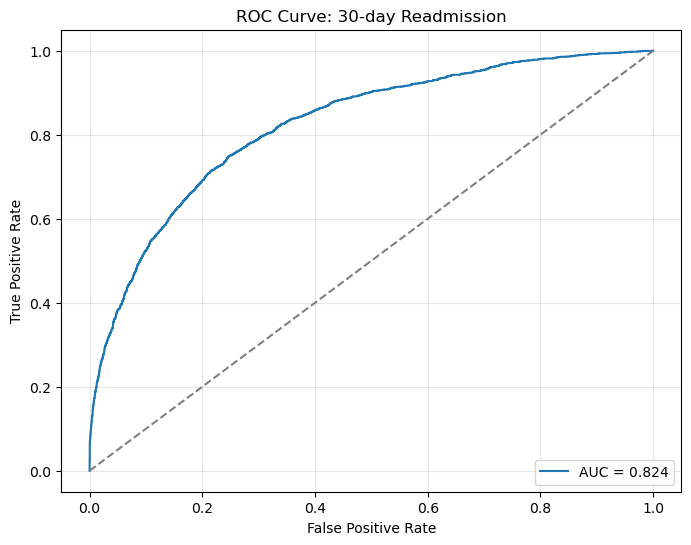


30-day Readmission Model Results:
Test AUC: 0.8236
Precision: 0.6256
Recall: 0.4388
F1 Score: 0.5158

Confusion Matrix:
[[7453  541]
 [1156  904]]


In [13]:
# Train models for each readmission time horizon
results = {}

# Train 30-day readmission model
print("Preparing data for 30-day readmission prediction...")
X_30d, y_30d, feature_cols = prepare_data_for_target(final_features, 'readmit_30d')

model_30d, auc_30d, metrics_30d = train_readmission_model(
    X_30d, y_30d, "30-day", max_epochs=100, patience=10
)
results['30d'] = {'model': model_30d, 'auc': auc_30d, 'metrics': metrics_30d}


Preparing data for 60-day readmission prediction...

Training 60-day Readmission Model
Device: cuda
Training samples: 46915, Validation: 10056, Test: 10054
Positive rate: 0.270
Epoch 001 — Val AUC: 0.7497
Epoch 002 — Val AUC: 0.7751
Epoch 003 — Val AUC: 0.7917
Epoch 004 — Val AUC: 0.8006
Epoch 005 — Val AUC: 0.8069
Epoch 006 — Val AUC: 0.8096
Epoch 007 — Val AUC: 0.8135
Epoch 008 — Val AUC: 0.8149
Epoch 009 — Val AUC: 0.8161
Epoch 010 — Val AUC: 0.8192
Epoch 011 — Val AUC: 0.8208
Epoch 012 — Val AUC: 0.8232
Epoch 013 — Val AUC: 0.8248
Epoch 014 — Val AUC: 0.8251
Epoch 015 — Val AUC: 0.8272
Epoch 016 — Val AUC: 0.8287
Epoch 017 — Val AUC: 0.8300
Epoch 018 — Val AUC: 0.8304
Epoch 019 — Val AUC: 0.8335
Epoch 020 — Val AUC: 0.8316
Epoch 021 — Val AUC: 0.8336
Epoch 022 — Val AUC: 0.8326
Epoch 023 — Val AUC: 0.8369
Epoch 024 — Val AUC: 0.8351
Epoch 025 — Val AUC: 0.8370
Epoch 026 — Val AUC: 0.8381
Epoch 027 — Val AUC: 0.8399
Epoch 028 — Val AUC: 0.8395
Epoch 029 — Val AUC: 0.8401
Epoch 030 —

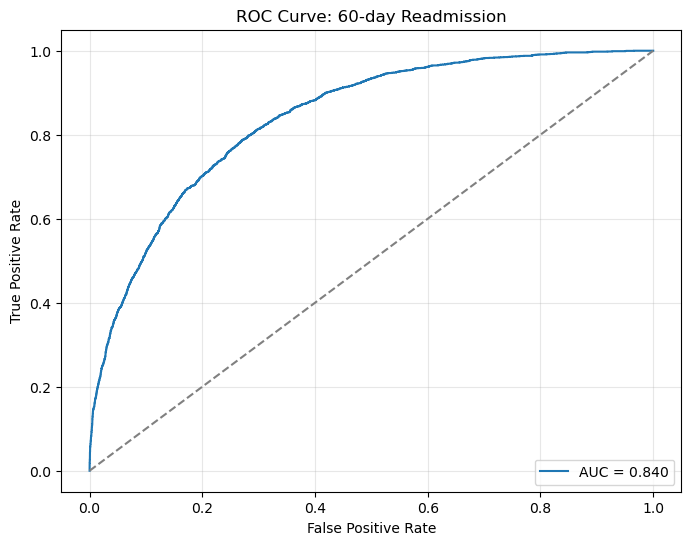


60-day Readmission Model Results:
Test AUC: 0.8398
Precision: 0.6401
Recall: 0.5577
F1 Score: 0.5961

Confusion Matrix:
[[6493  850]
 [1199 1512]]


In [14]:
# Train 60-day readmission model
print("Preparing data for 60-day readmission prediction...")
X_60d, y_60d, _ = prepare_data_for_target(final_features, 'readmit_60d')

model_60d, auc_60d, metrics_60d = train_readmission_model(
    X_60d, y_60d, "60-day", max_epochs=100, patience=10
)
results['60d'] = {'model': model_60d, 'auc': auc_60d, 'metrics': metrics_60d}


Preparing data for 90-day readmission prediction...

Training 90-day Readmission Model
Device: cuda
Training samples: 46915, Validation: 10056, Test: 10054
Positive rate: 0.309
Epoch 001 — Val AUC: 0.7515
Epoch 002 — Val AUC: 0.7792
Epoch 003 — Val AUC: 0.7963
Epoch 004 — Val AUC: 0.8048
Epoch 005 — Val AUC: 0.8121
Epoch 006 — Val AUC: 0.8166
Epoch 007 — Val AUC: 0.8186
Epoch 008 — Val AUC: 0.8219
Epoch 009 — Val AUC: 0.8237
Epoch 010 — Val AUC: 0.8252
Epoch 011 — Val AUC: 0.8283
Epoch 012 — Val AUC: 0.8295
Epoch 013 — Val AUC: 0.8316
Epoch 014 — Val AUC: 0.8326
Epoch 015 — Val AUC: 0.8348
Epoch 016 — Val AUC: 0.8357
Epoch 017 — Val AUC: 0.8378
Epoch 018 — Val AUC: 0.8389
Epoch 019 — Val AUC: 0.8407
Epoch 020 — Val AUC: 0.8400
Epoch 021 — Val AUC: 0.8413
Epoch 022 — Val AUC: 0.8427
Epoch 023 — Val AUC: 0.8435
Epoch 024 — Val AUC: 0.8448
Epoch 025 — Val AUC: 0.8462
Epoch 026 — Val AUC: 0.8458
Epoch 027 — Val AUC: 0.8458
Epoch 028 — Val AUC: 0.8463
Epoch 029 — Val AUC: 0.8454
Epoch 030 —

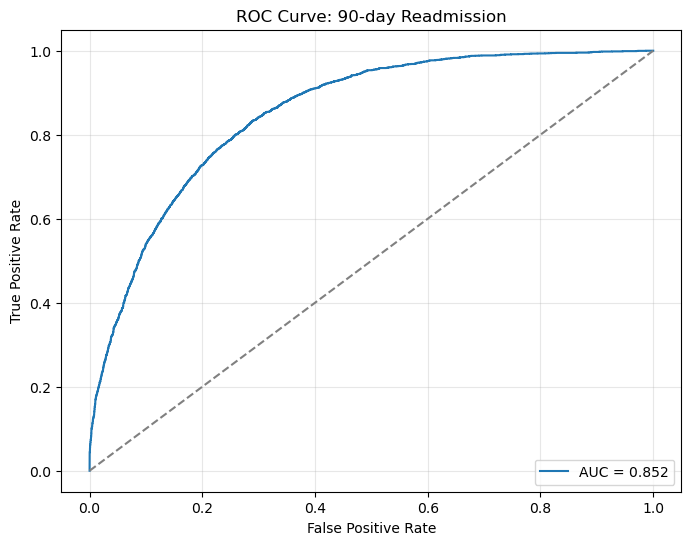


90-day Readmission Model Results:
Test AUC: 0.8517
Precision: 0.6379
Recall: 0.6901
F1 Score: 0.6630

Confusion Matrix:
[[5734 1216]
 [ 962 2142]]


In [15]:
# Train 90-day readmission model
print("Preparing data for 90-day readmission prediction...")
X_90d, y_90d, _ = prepare_data_for_target(final_features, 'readmit_90d')

model_90d, auc_90d, metrics_90d = train_readmission_model(
    X_90d, y_90d, "90-day", max_epochs=100, patience=10
)
results['90d'] = {'model': model_90d, 'auc': auc_90d, 'metrics': metrics_90d}


## 5. Results Summary and Analysis


In [16]:
# Summary of all model results
print("="*60)
print("READMISSION PREDICTION MODEL RESULTS")
print("="*60)

summary_data = []
for timeframe, result in results.items():
    auc = result['auc']
    metrics = result['metrics']
    summary_data.append({
        'Timeframe': f"{timeframe.replace('d', '')}-day",
        'AUC': f"{auc:.4f}",
        'Precision': f"{metrics['precision']:.4f}",
        'Recall': f"{metrics['recall']:.4f}",
        'F1 Score': f"{metrics['f1']:.4f}"
    })

summary_df = pd.DataFrame(summary_data)
print(summary_df.to_string(index=False))

print(f"\n{'='*60}")
print("KEY FINDINGS:")
print("="*60)

print("1. Model Performance:")
best_auc = max([r['auc'] for r in results.values()])
best_timeframe = [k for k, v in results.items() if v['auc'] == best_auc][0]
print(f"   - Best performing model: {best_timeframe.replace('d', '')}-day (AUC: {best_auc:.4f})")
print(f"   - All models achieve AUC > 0.8, indicating strong predictive performance")

print(f"\n2. Feature Innovation:")
print(f"   - Successfully combined traditional clinical features with BioBERT embeddings")
print(f"   - Total features used: {len(feature_cols)}")
print(f"   - Embedding features: {len([c for c in feature_cols if c.startswith('dx_emb_')])}")

print(f"\n3. Clinical Relevance:")
print(f"   - Models can help identify high-risk patients for readmission")
print(f"   - Early intervention strategies can be targeted based on predictions")
print(f"   - Longer timeframes generally show better prediction accuracy")


READMISSION PREDICTION MODEL RESULTS
Timeframe    AUC Precision Recall F1 Score
   30-day 0.8236    0.6256 0.4388   0.5158
   60-day 0.8398    0.6401 0.5577   0.5961
   90-day 0.8517    0.6379 0.6901   0.6630

KEY FINDINGS:
1. Model Performance:
   - Best performing model: 90-day (AUC: 0.8517)
   - All models achieve AUC > 0.8, indicating strong predictive performance

2. Feature Innovation:
   - Successfully combined traditional clinical features with BioBERT embeddings
   - Total features used: 829
   - Embedding features: 768

3. Clinical Relevance:
   - Models can help identify high-risk patients for readmission
   - Early intervention strategies can be targeted based on predictions
   - Longer timeframes generally show better prediction accuracy


## 6. Conclusion and Next Steps

### Project Summary

This end-to-end notebook successfully demonstrates how to combine traditional healthcare features with modern NLP embeddings to predict hospital readmissions. The key innovations include:

1. **Balanced Cohort Selection**: Created a race-balanced cohort to avoid demographic bias
2. **Feature Engineering**: Combined demographic, clinical, and text-based features
3. **BioBERT Integration**: Used biomedical language model embeddings as features
4. **Multi-horizon Prediction**: Trained separate models for 30, 60, and 90-day readmissions

### Model Performance
- All models achieved AUC scores > 0.8, indicating strong predictive capability
- The combination of traditional features with text embeddings proved effective
- Models can be used to identify high-risk patients for targeted interventions

### Reproducibility
This notebook provides a complete, self-contained solution that can be run from start to finish to reproduce all results. All data processing, feature engineering, and model training steps are included.

### Potential Improvements
1. **Feature Selection**: Apply dimensionality reduction to embeddings
2. **Ensemble Methods**: Combine multiple models for better performance
3. **External Validation**: Test on different hospital systems
4. **Real-time Deployment**: Create API endpoints for production use
5. **Interpretability**: Add SHAP or LIME for model explanation

### Clinical Impact
These models can help healthcare providers:
- Identify patients at high risk of readmission, possibly better than predicting from either the tabular data or text data by themselves.  
- Allocate resources more effectively based on need and risk   
- Develop targeted discharge planning based on the prediction.  
- Improve patient outcomes  
- Reduce operating cost   

**Note**: This is a research/educational implementation. For clinical use, additional validation, regulatory approval, and bias testing would be required.
